## 1.1 PCA分析法 

In [1]:
from matplotlib import patches
from torchvision.transforms import transforms
from PIL import Image
import seaborn
import torch
from torch import nn
import numpy
from train import get_options
from models.base_clip.CLIP import load_clip_from_json
import torch
from torch import nn
from torchvision.transforms import transforms

from sklearn import decomposition
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

image = Image.open(r"D:\Code\Pycharm\Project\analysis\airport_7.tif").convert('RGB')
image_tensor = image_transform(image).unsqueeze(0)


def encoderImage(x, path):
    # self = torch.load("D:\Code\Pycharm\Project/analysis/" + path + ".pt")
    self, self.clip_config = load_clip_from_json(
        config_path=r"D:\Code\Pycharm\Project\models_data\base_clip/" + path + "/",
        pre_train=path + ".pt",
    )
    self.load_state_dict(torch.load("D:\Code\Pycharm\Project/analysis/" + path + ".pt"))
    self = self.visual
    x = self.conv1(x)  # shape = [*, width, grid, grid] # 将图片分成[32,32]个patch [1,768,7,7]
    x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2],合并高宽 [1,768,49]
    x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width] ，更换位置 [1,49,768]
    x = torch.cat(
        [self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device),
         x], dim=1)  # shape = [*, grid ** 2 + 1, width],添加cls token[1,50,768]
    x = x + self.positional_embedding.to(x.dtype)  # 这里位置编码是可学习的参数，可能是切了path顺序让模型自己学习吧  [1,50,768]
    x = self.ln_pre(x)  # [1,50,768]

    x = x.permute(1, 0, 2)  # NLD -> LND  # [pixel,b,d_model]=[50,1,768]
    # 当实例化时 batch——first默认维false
    x = self.transformer(x)  # 多头transformer [50,1,768]
    x = x.permute(1, 0, 2)  # LND -> NLD  # [1,50,768]
    feature = x.squeeze().detach().numpy()
    pca = decomposition.PCA(n_components=3)
    pca.fit(feature)
    new_feature = pca.transform(feature)
    fig = plt.figure(figsize=(10, 7), dpi=100)
    ax = plt.axes(projection="3d")
    # Creating plot
    ax.scatter3D(new_feature[:, 0], new_feature[:, 1], new_feature[:, 2])
    plt.title(path)
    plt.show()

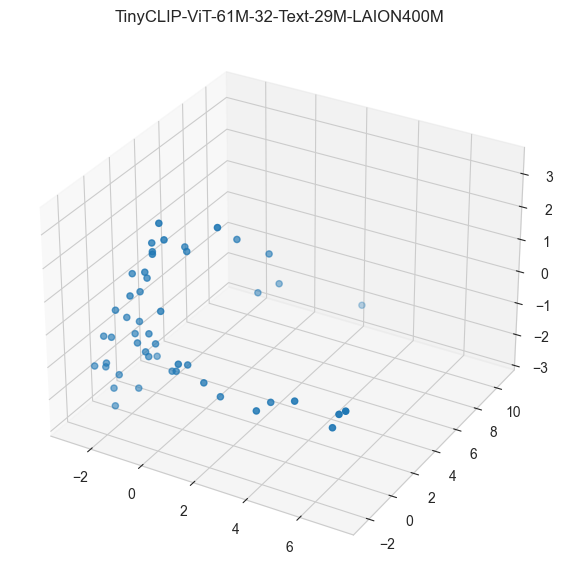

In [5]:
encoderImage(image_tensor, "TinyCLIP-ViT-61M-32-Text-29M-LAION400M")

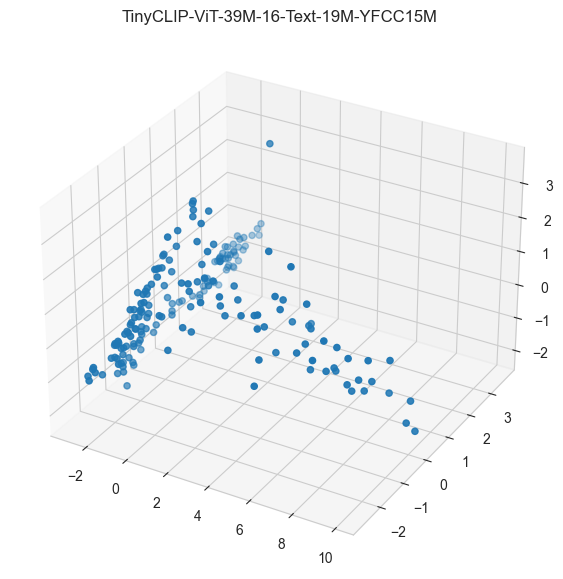

In [6]:
encoderImage(image_tensor, "TinyCLIP-ViT-39M-16-Text-19M-YFCC15M")

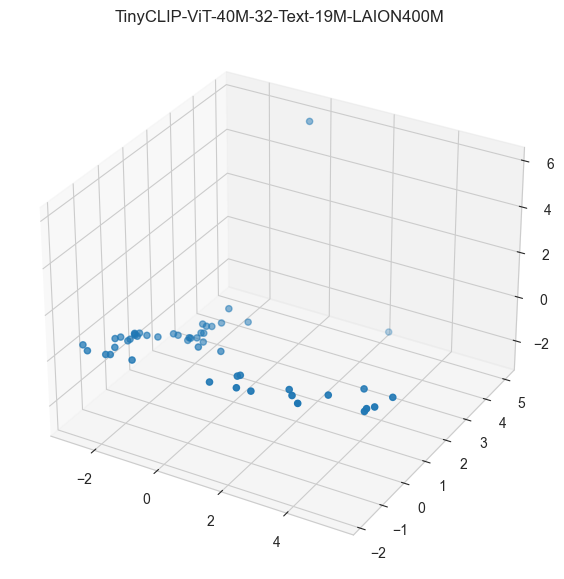

In [7]:
encoderImage(image_tensor, "TinyCLIP-ViT-40M-32-Text-19M-LAION400M")

## 1.2 相关度曲线

<Axes: >

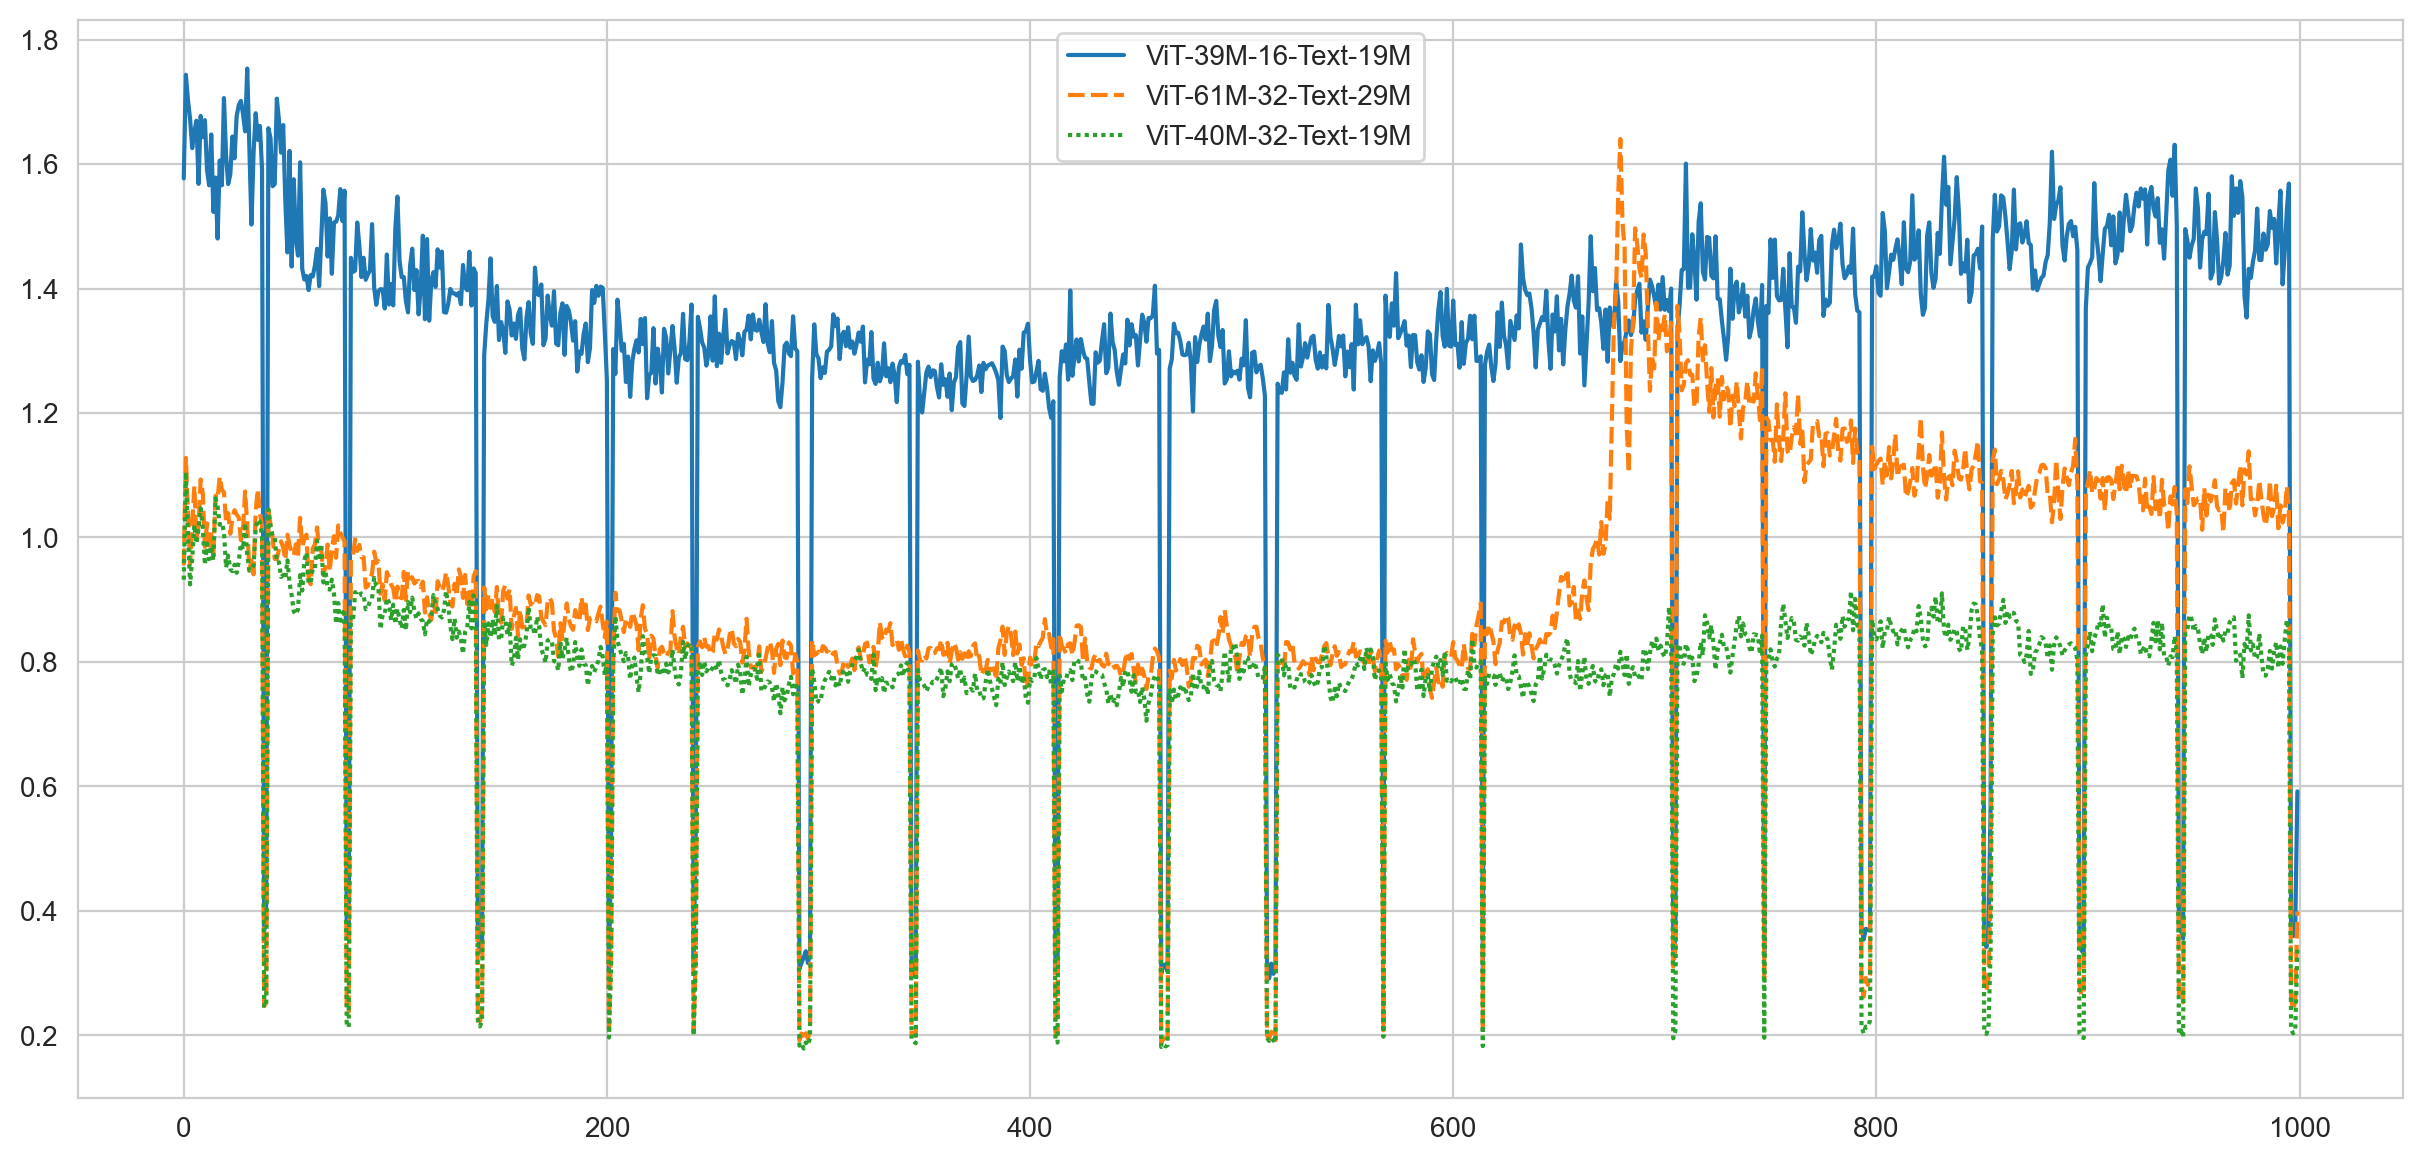

In [17]:
import seaborn
import pandas
import matplotlib.pyplot as plt

seaborn.set_style("whitegrid")
patch_16 = pandas.read_csv("analysis/16-csv.csv")
patch_32 = pandas.read_csv("analysis/32-csv.csv")
patch_32_2 = pandas.read_csv("analysis/40M-32-Text-19M.csv")
df3 = pandas.merge(patch_16, patch_32, how='inner', on='Step')
df3 = pandas.merge(df3, patch_32_2, how='inner', on='Step')
df3["ViT-39M-16-Text-19M"] = df3.Value_x
df3["ViT-61M-32-Text-29M"] = df3.Value_y
df3["ViT-40M-32-Text-19M"] = df3.Value
plt.figure(figsize=(15, 7), dpi=200)
seaborn.lineplot(data=df3[["ViT-39M-16-Text-19M", "ViT-61M-32-Text-29M", "ViT-40M-32-Text-19M"]])

## Attention Visual

In [20]:
%reset -f
from Collection import VarCollection, visualize_grid_to_grid_with_cls, visualize_grid_to_grid

VarCollection.activate()
from PIL import Image
import seaborn
import torch
from torch import nn
import numpy
from models.base_clip.CLIP import load_clip_from_json
import torch
from torch import nn
from torchvision.transforms import transforms

from sklearn import decomposition
import matplotlib.pyplot as plt

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

# TinyCLIP-ViT-61M-32-Text-29M-LAION400M
# TinyCLIP-ViT-39M-16-Text-19M-YFCC15M 
# TinyCLIP-ViT-40M-32-Text-19M-LAION400M
path = "TinyCLIP-ViT-39M-16-Text-19M-YFCC15M"
self, self.clip_config = load_clip_from_json(
    config_path=r"D:\Code\Pycharm\Project\models_data\base_clip/" + path + "/",
    pre_train=True,
)
self.eval()
self.load_state_dict(torch.load("D:\Code\Pycharm\Project/analysis/" + path + ".pt"))
visual_encoder = self.visual

# image = Image.open(r"D:\Code\Pycharm\Project\dataset\RSITMD\images/airport_505.tif").convert('RGB')
image = Image.open(r"D:\Code\Pycharm\Project\analysis\airport_7.tif").convert('RGB')
image_tensor = image_transform(image).unsqueeze(0)
image = image.resize((224, 224))
VarCollection.clear()
with torch.no_grad():
    feature = visual_encoder(image_tensor)
cache = VarCollection.cache
print(list(cache.keys()))

['ResidualAttentionBlock.forward']


In [21]:
attention_maps = cache['ResidualAttentionBlock.forward']
print(len(attention_maps))
print(attention_maps[0].shape)

12
(1, 8, 197, 197)


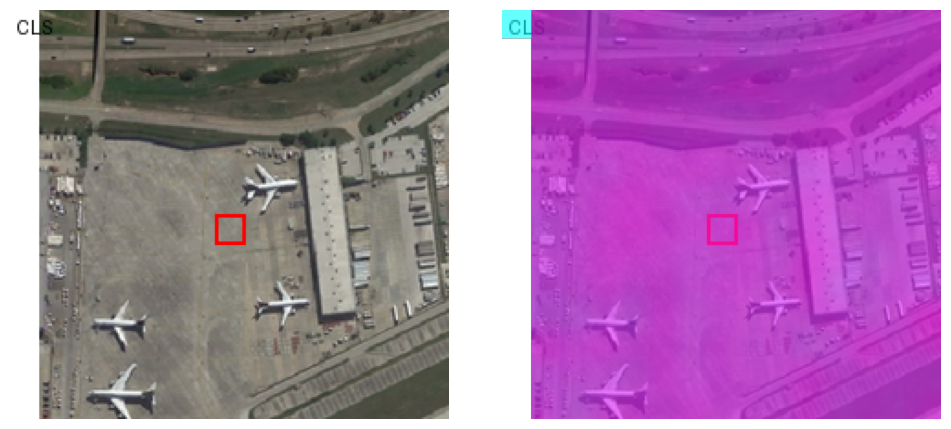

In [22]:
# for i in range(11):


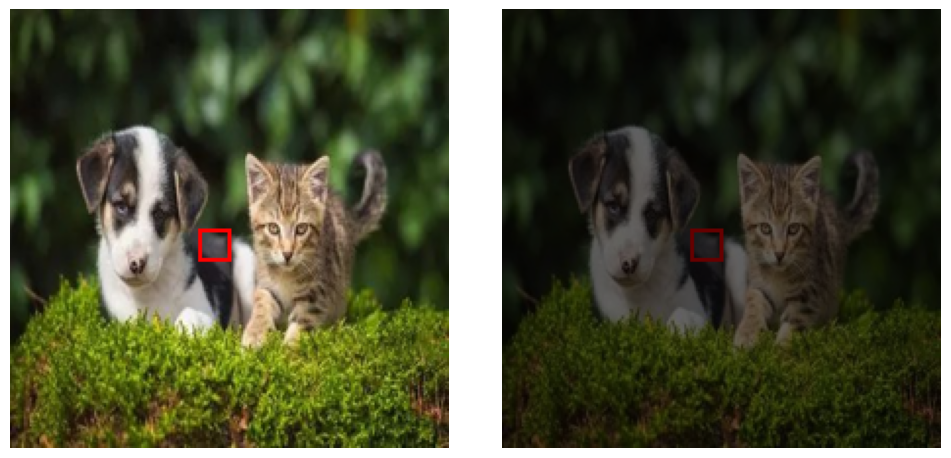

In [9]:
# attention_maps[11][0, 22, 10:20] = 1
# for i in range(11):
visualize_grid_to_grid(attention_maps[11][0, 4, 1:, 1:], 104, image, grid_size=14)  # 22

In [ ]:
attention_maps[11][:, 0, :]

In [65]:
attention_maps[11][:, 22, :]


array([[0.00669606, 0.00525078, 0.0050619 , 0.00555277, 0.00558755,
        0.0052231 , 0.00484034, 0.00517522, 0.00493049, 0.00483196,
        0.00480899, 0.00501998, 0.00552304, 0.00487758, 0.00517375,
        0.00543713, 0.00534605, 0.00558613, 0.00541809, 0.0049228 ,
        0.00556486, 0.00509098, 0.00504584, 0.00505042, 0.00500225,
        0.00478221, 0.00486684, 0.00482006, 0.00519729, 0.00504489,
        0.00499125, 0.00502464, 0.00520763, 0.00497246, 0.00542077,
        0.00509713, 0.00497533, 0.00480808, 0.00466593, 0.00517701,
        0.00537363, 0.00478625, 0.00468843, 0.00498424, 0.0052245 ,
        0.00489185, 0.0053878 , 0.00551421, 0.00488556, 0.00495888,
        0.00487931, 0.004756  , 0.00495306, 0.0051375 , 0.00527523,
        0.00498259, 0.00476208, 0.00506704, 0.00530935, 0.00545575,
        0.00547931, 0.00532456, 0.00512191, 0.00538821, 0.00487836,
        0.00520473, 0.00530181, 0.00496422, 0.00533645, 0.00527731,
        0.00497504, 0.00491581, 0.00514986, 0.00

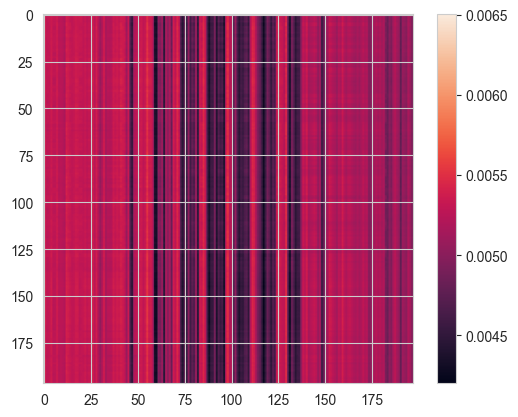

In [13]:
from Collection import visualize_head

visualize_head(attention_maps[11][0, 1])